# Ablation Study 2.3: Temperature Parameter Analysis

## Motivation

The temperature parameter controls the steepness of the spike activation function in the LIF (Leaky Integrate-and-Fire) neurons. It affects gradient flow during backpropagation and the spiking behavior of neurons. This ablation examines how different temperature values impact model performance and training dynamics.

## Experimental Plan

1. Test temperature values: [1.0, 3.0, 5.0, 7.0, 10.0]
2. Keep all other hyperparameters constant (step=1, spike=True)
3. Train models on ModelNet40 dataset
4. Compare accuracy, convergence speed, and training stability

## Expected Insight

This experiment reveals the optimal temperature setting for gradient flow and spiking dynamics. Lower temperatures may lead to more binary-like activations, while higher temperatures provide smoother gradients but may reduce the biological plausibility of the spiking behavior.

## Dataset Setup

Before running this notebook, ensure the ModelNet40 dataset is downloaded and extracted to: `data/modelnet40_normal_resampled/`

In [1]:
import os
import sys
import torch
import numpy as np
import datetime
import importlib
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('..')
from data_utils.ModelNetDataLoader import ModelNetDataLoader
from models.spike_model import SpikeModel
import provider

print('Imports successful!')
from cache_utils import load_training_history, save_training_history, cache_checkpoint, load_cached_checkpoint_path, best_metric
from viz_utils import plot_training_curves, summarize_histories, plot_metric_table, plot_metric_bars


Imports successful!


## Configuration for Different Temperature Values

In [2]:
class Args:
    def __init__(self, temp=5.0, num_category=40):
        self.use_cpu = False
        self.gpu = '0'
        self.batch_size = 24
        self.model = 'pointnet_cls'
        self.num_category = num_category
        self.epoch = 100
        self.learning_rate = 0.001
        self.num_point = 1024
        self.optimizer = 'Adam'
        self.log_dir = f'ablation_temp{temp}_modelnet{num_category}'
        self.decay_rate = 1e-4
        self.use_normals = False
        self.process_data = False
        self.use_uniform_sample = False
        self.step = 1
        self.spike = True
        self.temp = temp

# Create configurations for different temperature values
temp_values = [1.0, 3.0, 5.0, 7.0, 10.0]
args_list = [Args(temp=t, num_category=40) for t in temp_values]

for args in args_list:
    print(f'Temperature {args.temp}: {args.log_dir}')

Temperature 1.0: ablation_temp1.0_modelnet40
Temperature 3.0: ablation_temp3.0_modelnet40
Temperature 5.0: ablation_temp5.0_modelnet40
Temperature 7.0: ablation_temp7.0_modelnet40
Temperature 10.0: ablation_temp10.0_modelnet40


## Helper Functions

In [3]:
def setup_experiment(args):
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    exp_dir = Path('../log/classification') / args.log_dir
    exp_dir.mkdir(parents=True, exist_ok=True)
    checkpoints_dir = exp_dir / 'checkpoints'
    checkpoints_dir.mkdir(exist_ok=True)
    return exp_dir, checkpoints_dir

def load_data(args):
    data_path = 'C:\\Users\\VIICTTE\\ML_Project\\modelnet40_normal_resampled'
    train_dataset = ModelNetDataLoader(root=data_path, args=args, split='train')
    test_dataset = ModelNetDataLoader(root=data_path, args=args, split='test')
    trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
    testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
    return trainDataLoader, testDataLoader

def create_model(args):
    sys.path.append('../models')
    model = importlib.import_module(args.model)
    classifier = model.get_model(args.num_category, normal_channel=args.use_normals)
    if args.spike:
        classifier = SpikeModel(classifier, args.step, args.temp)
        classifier.set_spike_state(True)
    criterion = model.get_loss()
    if not args.use_cpu:
        classifier = classifier.cuda()
        criterion = criterion.cuda()
    return classifier, criterion

print('Helper functions defined!')

Helper functions defined!


## Training Function

In [4]:
def train_model(args, exp_dir, checkpoints_dir, max_epochs=None):
    if max_epochs:
        args.epoch = max_epochs
    trainDataLoader, testDataLoader = load_data(args)
    classifier, criterion = create_model(args)
    
    optimizer = torch.optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.decay_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
    
    best_acc = 0.0
    history = []
    
    print(f'Training with temperature={args.temp}')
    
    for epoch in range(args.epoch):
        print(f'Epoch {epoch+1}/{args.epoch}')
        classifier.train()
        scheduler.step()
        mean_correct = []
        
        for points, target in tqdm(trainDataLoader):
            optimizer.zero_grad()
            points = points.data.numpy()
            points = provider.random_point_dropout(points)
            points[:,:,0:3] = provider.random_scale_point_cloud(points[:,:,0:3])
            points[:,:,0:3] = provider.shift_point_cloud(points[:,:,0:3])
            points = torch.Tensor(points).transpose(2, 1)
            if not args.use_cpu:
                points, target = points.cuda(), target.cuda()
            pred, trans_feat = classifier(points)
            loss = criterion(pred, target.long(), trans_feat)
            loss.backward()
            optimizer.step()
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.long().data).cpu().sum()
            mean_correct.append(correct.item() / float(points.size()[0]))
        
        train_acc = np.mean(mean_correct)
        
        with torch.no_grad():
            classifier.eval()
            test_correct = []
            for points, target in testDataLoader:
                if not args.use_cpu:
                    points, target = points.cuda(), target.cuda()
                points = points.transpose(2, 1)
                pred, _ = classifier(points)
                pred_choice = pred.data.max(1)[1]
                correct = pred_choice.eq(target.long().data).cpu().sum()
                test_correct.append(correct.item() / float(points.size()[0]))
            test_acc = np.mean(test_correct)
        
        print(f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        history.append({'epoch': epoch+1, 'train_acc': train_acc, 'test_acc': test_acc})
        
        if test_acc >= best_acc:
            best_acc = test_acc
            torch.save({'model_state_dict': classifier.state_dict()}, str(checkpoints_dir / 'best_model.pth'))
    
    return classifier, history, best_acc

print('Training function defined!')

Training function defined!


## Train Models with Different Temperature Values

**Note**: Training takes significant time. Consider reducing epochs for testing.

In [6]:
# Train models with different temperature values
BASELINE_CACHE_NAME = 'baseline_step_1'
results = {}

for args in args_list:
    print(f"=== Training with Temperature={args.temp} ===")
    is_baseline = getattr(args, 'temp', None) == 5.0 and getattr(args, 'step', None) == 1

    if is_baseline:
        baseline_history, baseline_meta = load_training_history(BASELINE_CACHE_NAME, with_metadata=True)
        if baseline_history:
            best_acc = best_metric(baseline_history, ['test_acc', 'test_instance_acc']) or 0.0
            print(f"Loaded cached baseline history with {len(baseline_history)} epoch(s). Best accuracy: {best_acc:.4f}")
            results[args.temp] = {
                'classifier': None,
                'history': baseline_history,
                'best_acc': best_acc,
                'metadata': baseline_meta,
            }
            cached_ckpt = load_cached_checkpoint_path(BASELINE_CACHE_NAME)
            if cached_ckpt:
                print(f'Cached baseline checkpoint available at: {cached_ckpt}')
            continue
        print('No cached baseline history found; training baseline temperature configuration from scratch.')

    exp_dir, ckpt_dir = setup_experiment(args)
    classifier, history, best_acc = train_model(args, exp_dir, ckpt_dir, max_epochs=100)

    if is_baseline:
        metadata = {
            'variant': 'baseline_step_1',
            'config': dict(vars(args)),
            'max_epochs': args.epoch,
        }
        history_path = save_training_history(history, BASELINE_CACHE_NAME, metadata=metadata)
        print(f'Saved baseline history to {history_path}')
        best_ckpt = ckpt_dir / 'best_model.pth'
        if best_ckpt.exists():
            cached_ckpt = cache_checkpoint(best_ckpt, BASELINE_CACHE_NAME)
            print(f'Cached baseline checkpoint to {cached_ckpt}')

    results[args.temp] = {
        'classifier': classifier,
        'history': history,
        'best_acc': best_acc,
    }
    print(f'Temperature={args.temp}: Best Accuracy = {best_acc:.4f}')

=== Training with Temperature=1.0 ===
The size of train data is 9843
The size of test data is 2468
Training with temperature=1.0
Epoch 1/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 21.97it/s]


Train Acc: 0.4318, Test Acc: 0.0473
Epoch 2/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.5800, Test Acc: 0.1007
Epoch 3/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.6329, Test Acc: 0.1618
Epoch 4/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.92it/s]


Train Acc: 0.6736, Test Acc: 0.1448
Epoch 5/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.89it/s]


Train Acc: 0.6940, Test Acc: 0.1145
Epoch 6/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.88it/s]


Train Acc: 0.7000, Test Acc: 0.0599
Epoch 7/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.7160, Test Acc: 0.1060
Epoch 8/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.7228, Test Acc: 0.0655
Epoch 9/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.80it/s]


Train Acc: 0.7290, Test Acc: 0.0599
Epoch 10/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.7394, Test Acc: 0.0494
Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.7403, Test Acc: 0.0813
Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.7420, Test Acc: 0.0720
Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.73it/s]


Train Acc: 0.7526, Test Acc: 0.0817
Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.7550, Test Acc: 0.0728
Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.63it/s]


Train Acc: 0.7576, Test Acc: 0.1222
Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.92it/s]


Train Acc: 0.7637, Test Acc: 0.1424
Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.7564, Test Acc: 0.0773
Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.7667, Test Acc: 0.0611
Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.94it/s]


Train Acc: 0.7682, Test Acc: 0.0902
Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.56it/s]


Train Acc: 0.7846, Test Acc: 0.1816
Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.97it/s]


Train Acc: 0.7867, Test Acc: 0.0510
Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.7894, Test Acc: 0.0878
Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.7920, Test Acc: 0.1557
Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.7961, Test Acc: 0.0922
Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.7938, Test Acc: 0.0680
Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.7980, Test Acc: 0.0821
Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.78it/s]


Train Acc: 0.7939, Test Acc: 0.0538
Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.05it/s]


Train Acc: 0.8035, Test Acc: 0.3795
Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.8018, Test Acc: 0.1218
Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.7975, Test Acc: 0.0979
Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8047, Test Acc: 0.5236
Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.80it/s]


Train Acc: 0.8015, Test Acc: 0.3981
Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.96it/s]


Train Acc: 0.8037, Test Acc: 0.6730
Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.8093, Test Acc: 0.2658
Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.8072, Test Acc: 0.4095
Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8069, Test Acc: 0.4496
Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8106, Test Acc: 0.6301
Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.14it/s]


Train Acc: 0.8134, Test Acc: 0.1351
Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.8123, Test Acc: 0.5992
Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8215, Test Acc: 0.6796
Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.64it/s]


Train Acc: 0.8209, Test Acc: 0.3209
Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.8277, Test Acc: 0.3780
Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.88it/s]


Train Acc: 0.8272, Test Acc: 0.1828
Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.80it/s]


Train Acc: 0.8296, Test Acc: 0.2468
Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.8297, Test Acc: 0.4477
Epoch 46/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.8240, Test Acc: 0.6767
Epoch 47/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.78it/s]


Train Acc: 0.8329, Test Acc: 0.7195
Epoch 48/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.61it/s]


Train Acc: 0.8263, Test Acc: 0.7854
Epoch 49/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.8305, Test Acc: 0.8036
Epoch 50/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8291, Test Acc: 0.7148
Epoch 51/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.62it/s]


Train Acc: 0.8287, Test Acc: 0.7585
Epoch 52/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.8317, Test Acc: 0.7572
Epoch 53/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.8324, Test Acc: 0.7171
Epoch 54/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.8327, Test Acc: 0.7945
Epoch 55/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.73it/s]


Train Acc: 0.8341, Test Acc: 0.6842
Epoch 56/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.00it/s]


Train Acc: 0.8337, Test Acc: 0.8193
Epoch 57/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8331, Test Acc: 0.7345
Epoch 58/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8336, Test Acc: 0.7646
Epoch 59/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8299, Test Acc: 0.7782
Epoch 60/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8389, Test Acc: 0.7919
Epoch 61/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.93it/s]


Train Acc: 0.8446, Test Acc: 0.7648
Epoch 62/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.48it/s]


Train Acc: 0.8440, Test Acc: 0.8077
Epoch 63/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.8448, Test Acc: 0.8271
Epoch 64/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.91it/s]


Train Acc: 0.8448, Test Acc: 0.8345
Epoch 65/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.78it/s]


Train Acc: 0.8433, Test Acc: 0.7661
Epoch 66/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.64it/s]


Train Acc: 0.8537, Test Acc: 0.8147
Epoch 67/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.60it/s]


Train Acc: 0.8491, Test Acc: 0.8202
Epoch 68/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.78it/s]


Train Acc: 0.8503, Test Acc: 0.7909
Epoch 69/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.8492, Test Acc: 0.8472
Epoch 70/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.97it/s]


Train Acc: 0.8479, Test Acc: 0.8416
Epoch 71/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.8480, Test Acc: 0.8129
Epoch 72/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.8518, Test Acc: 0.8405
Epoch 73/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.8492, Test Acc: 0.8159
Epoch 74/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8484, Test Acc: 0.8494
Epoch 75/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.8476, Test Acc: 0.8439
Epoch 76/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.8541, Test Acc: 0.8488
Epoch 77/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8514, Test Acc: 0.8505
Epoch 78/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.92it/s]


Train Acc: 0.8545, Test Acc: 0.8573
Epoch 79/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.8509, Test Acc: 0.8505
Epoch 80/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.52it/s]


Train Acc: 0.8584, Test Acc: 0.8485
Epoch 81/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.78it/s]


Train Acc: 0.8595, Test Acc: 0.8543
Epoch 82/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.96it/s]


Train Acc: 0.8566, Test Acc: 0.8675
Epoch 83/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.93it/s]


Train Acc: 0.8605, Test Acc: 0.8566
Epoch 84/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.8615, Test Acc: 0.8497
Epoch 85/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.8649, Test Acc: 0.8517
Epoch 86/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8630, Test Acc: 0.8585
Epoch 87/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.98it/s]


Train Acc: 0.8649, Test Acc: 0.8603
Epoch 88/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.8650, Test Acc: 0.8552
Epoch 89/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.8631, Test Acc: 0.8623
Epoch 90/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.94it/s]


Train Acc: 0.8651, Test Acc: 0.8596
Epoch 91/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.89it/s]


Train Acc: 0.8647, Test Acc: 0.8607
Epoch 92/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.59it/s]


Train Acc: 0.8655, Test Acc: 0.8549
Epoch 93/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.8668, Test Acc: 0.8595
Epoch 94/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.88it/s]


Train Acc: 0.8601, Test Acc: 0.8628
Epoch 95/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.8631, Test Acc: 0.8537
Epoch 96/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8672, Test Acc: 0.8588
Epoch 97/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.8704, Test Acc: 0.8612
Epoch 98/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8632, Test Acc: 0.8612
Epoch 99/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8622, Test Acc: 0.8591
Epoch 100/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.8704, Test Acc: 0.8648
Temperature=1.0: Best Accuracy = 0.8675
=== Training with Temperature=3.0 ===
The size of train data is 9843
The size of test data is 2468
Training with temperature=3.0
Epoch 1/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.88it/s]


Train Acc: 0.4381, Test Acc: 0.2549
Epoch 2/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.64it/s]


Train Acc: 0.5751, Test Acc: 0.0566
Epoch 3/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.93it/s]


Train Acc: 0.6298, Test Acc: 0.0566
Epoch 4/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.67it/s]


Train Acc: 0.6705, Test Acc: 0.1003
Epoch 5/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.94it/s]


Train Acc: 0.6919, Test Acc: 0.1380
Epoch 6/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.7046, Test Acc: 0.0765
Epoch 7/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.7106, Test Acc: 0.0708
Epoch 8/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.86it/s]


Train Acc: 0.7268, Test Acc: 0.1862
Epoch 9/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.73it/s]


Train Acc: 0.7331, Test Acc: 0.0522
Epoch 10/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.7401, Test Acc: 0.0867
Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.7455, Test Acc: 0.0562
Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.7484, Test Acc: 0.0481
Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.7560, Test Acc: 0.0182
Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.7592, Test Acc: 0.1084
Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.7614, Test Acc: 0.0659
Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.94it/s]


Train Acc: 0.7619, Test Acc: 0.0441
Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.64it/s]


Train Acc: 0.7662, Test Acc: 0.0405
Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.52it/s]


Train Acc: 0.7742, Test Acc: 0.0336
Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.7697, Test Acc: 0.0971
Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.7854, Test Acc: 0.1274
Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.7870, Test Acc: 0.2077
Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.86it/s]


Train Acc: 0.7896, Test Acc: 0.0972
Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.94it/s]


Train Acc: 0.7893, Test Acc: 0.1280
Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.53it/s]


Train Acc: 0.8008, Test Acc: 0.0858
Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.54it/s]


Train Acc: 0.7996, Test Acc: 0.1250
Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.93it/s]


Train Acc: 0.7979, Test Acc: 0.1100
Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.7997, Test Acc: 0.1109
Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.8012, Test Acc: 0.1498
Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.78it/s]


Train Acc: 0.7991, Test Acc: 0.1384
Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.61it/s]


Train Acc: 0.8062, Test Acc: 0.1329
Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.78it/s]


Train Acc: 0.8082, Test Acc: 0.2044
Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.92it/s]


Train Acc: 0.8073, Test Acc: 0.1242
Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.80it/s]


Train Acc: 0.8070, Test Acc: 0.1735
Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.8082, Test Acc: 0.1615
Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8051, Test Acc: 0.1367
Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.66it/s]


Train Acc: 0.8134, Test Acc: 0.1436
Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.8105, Test Acc: 0.1562
Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.8045, Test Acc: 0.1634
Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.8096, Test Acc: 0.2211
Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.78it/s]


Train Acc: 0.8197, Test Acc: 0.1741
Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8242, Test Acc: 0.2154
Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.8282, Test Acc: 0.2223
Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8259, Test Acc: 0.1523
Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.8285, Test Acc: 0.1911
Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8301, Test Acc: 0.1834
Epoch 46/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8302, Test Acc: 0.2263
Epoch 47/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.8274, Test Acc: 0.1850
Epoch 48/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8316, Test Acc: 0.2183
Epoch 49/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.8327, Test Acc: 0.1996
Epoch 50/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.56it/s]


Train Acc: 0.8283, Test Acc: 0.2065
Epoch 51/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.60it/s]


Train Acc: 0.8292, Test Acc: 0.2260
Epoch 52/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8308, Test Acc: 0.2414
Epoch 53/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.63it/s]


Train Acc: 0.8294, Test Acc: 0.2206
Epoch 54/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.65it/s]


Train Acc: 0.8317, Test Acc: 0.2183
Epoch 55/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.88it/s]


Train Acc: 0.8325, Test Acc: 0.2656
Epoch 56/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.8254, Test Acc: 0.2036
Epoch 57/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.67it/s]


Train Acc: 0.8308, Test Acc: 0.2036
Epoch 58/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8294, Test Acc: 0.2316
Epoch 59/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.8274, Test Acc: 0.2583
Epoch 60/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8339, Test Acc: 0.8515
Epoch 61/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.8366, Test Acc: 0.3624
Epoch 62/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.02it/s]


Train Acc: 0.8370, Test Acc: 0.1716
Epoch 63/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.67it/s]


Train Acc: 0.8367, Test Acc: 0.8540
Epoch 64/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8398, Test Acc: 0.8523
Epoch 65/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.88it/s]


Train Acc: 0.8413, Test Acc: 0.2101
Epoch 66/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.00it/s]


Train Acc: 0.8479, Test Acc: 0.6023
Epoch 67/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.57it/s]


Train Acc: 0.8405, Test Acc: 0.8498
Epoch 68/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.96it/s]


Train Acc: 0.8378, Test Acc: 0.8426
Epoch 69/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8479, Test Acc: 0.1784
Epoch 70/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.93it/s]


Train Acc: 0.8493, Test Acc: 0.7434
Epoch 71/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8439, Test Acc: 0.8469
Epoch 72/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.92it/s]


Train Acc: 0.8443, Test Acc: 0.8469
Epoch 73/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.46it/s]


Train Acc: 0.8450, Test Acc: 0.8504
Epoch 74/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8443, Test Acc: 0.8443
Epoch 75/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.8536, Test Acc: 0.8575
Epoch 76/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.98it/s]


Train Acc: 0.8494, Test Acc: 0.8350
Epoch 77/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.8448, Test Acc: 0.8541
Epoch 78/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.94it/s]


Train Acc: 0.8508, Test Acc: 0.8511
Epoch 79/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8490, Test Acc: 0.8280
Epoch 80/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8505, Test Acc: 0.8534
Epoch 81/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8520, Test Acc: 0.8577
Epoch 82/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.86it/s]


Train Acc: 0.8517, Test Acc: 0.8554
Epoch 83/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8520, Test Acc: 0.8502
Epoch 84/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:27<00:00, 15.06it/s]


Train Acc: 0.8555, Test Acc: 0.8590
Epoch 85/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8556, Test Acc: 0.8457
Epoch 86/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.8571, Test Acc: 0.8655
Epoch 87/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.56it/s]


Train Acc: 0.8627, Test Acc: 0.8574
Epoch 88/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.56it/s]


Train Acc: 0.8565, Test Acc: 0.8566
Epoch 89/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.94it/s]


Train Acc: 0.8552, Test Acc: 0.8622
Epoch 90/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8596, Test Acc: 0.8644
Epoch 91/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.66it/s]


Train Acc: 0.8572, Test Acc: 0.8605
Epoch 92/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.65it/s]


Train Acc: 0.8613, Test Acc: 0.8554
Epoch 93/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.8578, Test Acc: 0.8654
Epoch 94/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.8587, Test Acc: 0.8508
Epoch 95/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.80it/s]


Train Acc: 0.8614, Test Acc: 0.8570
Epoch 96/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8599, Test Acc: 0.8509
Epoch 97/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8602, Test Acc: 0.8651
Epoch 98/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8554, Test Acc: 0.8656
Epoch 99/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8657, Test Acc: 0.8607
Epoch 100/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.63it/s]


Train Acc: 0.8636, Test Acc: 0.8596
Temperature=3.0: Best Accuracy = 0.8656
=== Training with Temperature=5.0 ===
Loaded cached baseline history with 200 epoch(s). Best accuracy: 0.8818
Cached baseline checkpoint available at: ..\artifacts\spikepointnet\checkpoints\baseline_step_1.pth
=== Training with Temperature=7.0 ===
The size of train data is 9843
The size of test data is 2468
Training with temperature=7.0
Epoch 1/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.4299, Test Acc: 0.0405
Epoch 2/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.5811, Test Acc: 0.0405
Epoch 3/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.6303, Test Acc: 0.0405
Epoch 4/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.78it/s]


Train Acc: 0.6683, Test Acc: 0.0405
Epoch 5/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.6803, Test Acc: 0.0510
Epoch 6/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.78it/s]


Train Acc: 0.6977, Test Acc: 0.0461
Epoch 7/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.66it/s]


Train Acc: 0.7161, Test Acc: 0.0678
Epoch 8/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.7170, Test Acc: 0.0755
Epoch 9/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.7318, Test Acc: 0.0785
Epoch 10/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.7355, Test Acc: 0.0583
Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.7354, Test Acc: 0.0845
Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.64it/s]


Train Acc: 0.7431, Test Acc: 0.0983
Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.7501, Test Acc: 0.0841
Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.7526, Test Acc: 0.1578
Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.65it/s]


Train Acc: 0.7581, Test Acc: 0.1929
Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.7613, Test Acc: 0.1862
Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.7652, Test Acc: 0.0684
Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.7647, Test Acc: 0.1735
Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.7694, Test Acc: 0.0659
Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.86it/s]


Train Acc: 0.7828, Test Acc: 0.1052
Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.7923, Test Acc: 0.2411
Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.7900, Test Acc: 0.2346
Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.7884, Test Acc: 0.1153
Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.00it/s]


Train Acc: 0.7917, Test Acc: 0.0222
Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.7961, Test Acc: 0.1044
Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.92it/s]


Train Acc: 0.7959, Test Acc: 0.1287
Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.66it/s]


Train Acc: 0.7965, Test Acc: 0.2429
Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.63it/s]


Train Acc: 0.7997, Test Acc: 0.0607
Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.88it/s]


Train Acc: 0.8058, Test Acc: 0.1351
Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.78it/s]


Train Acc: 0.8037, Test Acc: 0.1015
Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8081, Test Acc: 0.3015
Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.86it/s]


Train Acc: 0.7999, Test Acc: 0.1621
Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.8048, Test Acc: 0.1320
Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.7989, Test Acc: 0.1044
Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.66it/s]


Train Acc: 0.8077, Test Acc: 0.3834
Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.8053, Test Acc: 0.2840
Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.73it/s]


Train Acc: 0.8035, Test Acc: 0.2897
Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.60it/s]


Train Acc: 0.8133, Test Acc: 0.1493
Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.95it/s]


Train Acc: 0.8099, Test Acc: 0.2416
Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.8195, Test Acc: 0.1776
Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.64it/s]


Train Acc: 0.8166, Test Acc: 0.5605
Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.8231, Test Acc: 0.5231
Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.8210, Test Acc: 0.5183
Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.93it/s]


Train Acc: 0.8247, Test Acc: 0.6464
Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.66it/s]


Train Acc: 0.8275, Test Acc: 0.6708
Epoch 46/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.73it/s]


Train Acc: 0.8328, Test Acc: 0.5800
Epoch 47/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.93it/s]


Train Acc: 0.8240, Test Acc: 0.4986
Epoch 48/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.67it/s]


Train Acc: 0.8213, Test Acc: 0.6544
Epoch 49/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8245, Test Acc: 0.6667
Epoch 50/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.88it/s]


Train Acc: 0.8292, Test Acc: 0.5979
Epoch 51/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8260, Test Acc: 0.6674
Epoch 52/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8280, Test Acc: 0.6916
Epoch 53/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8292, Test Acc: 0.6631
Epoch 54/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.80it/s]


Train Acc: 0.8245, Test Acc: 0.6700
Epoch 55/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.8324, Test Acc: 0.6904
Epoch 56/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.8329, Test Acc: 0.6901
Epoch 57/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.8323, Test Acc: 0.6659
Epoch 58/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.59it/s]


Train Acc: 0.8286, Test Acc: 0.6942
Epoch 59/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8336, Test Acc: 0.7400
Epoch 60/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.89it/s]


Train Acc: 0.8391, Test Acc: 0.7649
Epoch 61/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.8432, Test Acc: 0.7343
Epoch 62/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.67it/s]


Train Acc: 0.8420, Test Acc: 0.7282
Epoch 63/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.8400, Test Acc: 0.6654
Epoch 64/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.96it/s]


Train Acc: 0.8429, Test Acc: 0.7611
Epoch 65/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8369, Test Acc: 0.7215
Epoch 66/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.65it/s]


Train Acc: 0.8407, Test Acc: 0.7574
Epoch 67/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.64it/s]


Train Acc: 0.8434, Test Acc: 0.7508
Epoch 68/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.8420, Test Acc: 0.7495
Epoch 69/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8423, Test Acc: 0.6658
Epoch 70/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.8470, Test Acc: 0.7504
Epoch 71/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.8422, Test Acc: 0.7568
Epoch 72/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.95it/s]


Train Acc: 0.8478, Test Acc: 0.7637
Epoch 73/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.73it/s]


Train Acc: 0.8427, Test Acc: 0.7503
Epoch 74/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.78it/s]


Train Acc: 0.8398, Test Acc: 0.7607
Epoch 75/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8495, Test Acc: 0.7828
Epoch 76/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8448, Test Acc: 0.7490
Epoch 77/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.8449, Test Acc: 0.7684
Epoch 78/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.8466, Test Acc: 0.7542
Epoch 79/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8379, Test Acc: 0.4592
Epoch 80/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8511, Test Acc: 0.7861
Epoch 81/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.88it/s]


Train Acc: 0.8507, Test Acc: 0.7826
Epoch 82/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.80it/s]


Train Acc: 0.8525, Test Acc: 0.8506
Epoch 83/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.80it/s]


Train Acc: 0.8584, Test Acc: 0.7733
Epoch 84/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.8577, Test Acc: 0.7751
Epoch 85/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8582, Test Acc: 0.8576
Epoch 86/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8516, Test Acc: 0.8582
Epoch 87/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.63it/s]


Train Acc: 0.8571, Test Acc: 0.8564
Epoch 88/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.8607, Test Acc: 0.3557
Epoch 89/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.56it/s]


Train Acc: 0.8568, Test Acc: 0.8618
Epoch 90/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8570, Test Acc: 0.8638
Epoch 91/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.8583, Test Acc: 0.8605
Epoch 92/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8629, Test Acc: 0.7689
Epoch 93/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.8546, Test Acc: 0.7915
Epoch 94/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.8553, Test Acc: 0.8656
Epoch 95/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.86it/s]


Train Acc: 0.8580, Test Acc: 0.5148
Epoch 96/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8622, Test Acc: 0.4823
Epoch 97/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.8623, Test Acc: 0.8657
Epoch 98/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8614, Test Acc: 0.8618
Epoch 99/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.8608, Test Acc: 0.7729
Epoch 100/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.8629, Test Acc: 0.8629
Temperature=7.0: Best Accuracy = 0.8657
=== Training with Temperature=10.0 ===
The size of train data is 9843
The size of test data is 2468
Training with temperature=10.0
Epoch 1/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.4337, Test Acc: 0.1319
Epoch 2/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.66it/s]


Train Acc: 0.5866, Test Acc: 0.1024
Epoch 3/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.60it/s]


Train Acc: 0.6372, Test Acc: 0.1675
Epoch 4/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.63it/s]


Train Acc: 0.6686, Test Acc: 0.1586
Epoch 5/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.6922, Test Acc: 0.1943
Epoch 6/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.7101, Test Acc: 0.2169
Epoch 7/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.7149, Test Acc: 0.2473
Epoch 8/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.65it/s]


Train Acc: 0.7186, Test Acc: 0.3601
Epoch 9/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.7359, Test Acc: 0.4133
Epoch 10/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.7355, Test Acc: 0.3518
Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.73it/s]


Train Acc: 0.7457, Test Acc: 0.1481
Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.86it/s]


Train Acc: 0.7497, Test Acc: 0.2869
Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.65it/s]


Train Acc: 0.7457, Test Acc: 0.2231
Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.7578, Test Acc: 0.1675
Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.7628, Test Acc: 0.0740
Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.7683, Test Acc: 0.0866
Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.7629, Test Acc: 0.0239
Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.7661, Test Acc: 0.2658
Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.63it/s]


Train Acc: 0.7771, Test Acc: 0.2358
Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.7910, Test Acc: 0.2342
Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.66it/s]


Train Acc: 0.7875, Test Acc: 0.3305
Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.7897, Test Acc: 0.3964
Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.7949, Test Acc: 0.4786
Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.86it/s]


Train Acc: 0.7964, Test Acc: 0.2557
Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.7952, Test Acc: 0.1537
Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8037, Test Acc: 0.0841
Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8064, Test Acc: 0.2006
Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.62it/s]


Train Acc: 0.8060, Test Acc: 0.2625
Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.64it/s]


Train Acc: 0.7976, Test Acc: 0.1282
Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.8017, Test Acc: 0.0955
Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8072, Test Acc: 0.1379
Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.78it/s]


Train Acc: 0.8116, Test Acc: 0.1088
Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.8062, Test Acc: 0.2203
Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.67it/s]


Train Acc: 0.8123, Test Acc: 0.2218
Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.80it/s]


Train Acc: 0.8096, Test Acc: 0.1849
Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.73it/s]


Train Acc: 0.8118, Test Acc: 0.2220
Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.63it/s]


Train Acc: 0.8076, Test Acc: 0.2848
Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8123, Test Acc: 0.2198
Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.8146, Test Acc: 0.1343
Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.73it/s]


Train Acc: 0.8203, Test Acc: 0.3083
Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.78it/s]


Train Acc: 0.8280, Test Acc: 0.2667
Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.8296, Test Acc: 0.3170
Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.8257, Test Acc: 0.3123
Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.61it/s]


Train Acc: 0.8245, Test Acc: 0.3218
Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.88it/s]


Train Acc: 0.8226, Test Acc: 0.2666
Epoch 46/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.84it/s]


Train Acc: 0.8302, Test Acc: 0.3509
Epoch 47/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8238, Test Acc: 0.3428
Epoch 48/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.8263, Test Acc: 0.2896
Epoch 49/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.67it/s]


Train Acc: 0.8324, Test Acc: 0.3046
Epoch 50/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.8292, Test Acc: 0.4155
Epoch 51/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.8274, Test Acc: 0.3434
Epoch 52/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.73it/s]


Train Acc: 0.8348, Test Acc: 0.4038
Epoch 53/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.87it/s]


Train Acc: 0.8346, Test Acc: 0.4181
Epoch 54/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.8301, Test Acc: 0.4105
Epoch 55/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.8294, Test Acc: 0.3299
Epoch 56/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.62it/s]


Train Acc: 0.8240, Test Acc: 0.3988
Epoch 57/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8271, Test Acc: 0.3818
Epoch 58/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.75it/s]


Train Acc: 0.8323, Test Acc: 0.4492
Epoch 59/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.8307, Test Acc: 0.4053
Epoch 60/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.86it/s]


Train Acc: 0.8363, Test Acc: 0.4315
Epoch 61/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.78it/s]


Train Acc: 0.8382, Test Acc: 0.4807
Epoch 62/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.8399, Test Acc: 0.5033
Epoch 63/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.62it/s]


Train Acc: 0.8428, Test Acc: 0.5146
Epoch 64/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.8450, Test Acc: 0.5197
Epoch 65/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.8463, Test Acc: 0.5175
Epoch 66/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.8360, Test Acc: 0.5592
Epoch 67/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8427, Test Acc: 0.4701
Epoch 68/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.66it/s]


Train Acc: 0.8415, Test Acc: 0.5155
Epoch 69/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.8419, Test Acc: 0.4903
Epoch 70/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.8425, Test Acc: 0.5010
Epoch 71/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.85it/s]


Train Acc: 0.8487, Test Acc: 0.5737
Epoch 72/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.92it/s]


Train Acc: 0.8439, Test Acc: 0.5499
Epoch 73/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.67it/s]


Train Acc: 0.8441, Test Acc: 0.5274
Epoch 74/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.68it/s]


Train Acc: 0.8471, Test Acc: 0.5340
Epoch 75/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.69it/s]


Train Acc: 0.8506, Test Acc: 0.5405
Epoch 76/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.8462, Test Acc: 0.3574
Epoch 77/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.83it/s]


Train Acc: 0.8483, Test Acc: 0.5536
Epoch 78/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8442, Test Acc: 0.4984
Epoch 79/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.76it/s]


Train Acc: 0.8440, Test Acc: 0.5591
Epoch 80/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.79it/s]


Train Acc: 0.8516, Test Acc: 0.5693
Epoch 81/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.81it/s]


Train Acc: 0.8512, Test Acc: 0.8060
Epoch 82/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8510, Test Acc: 0.5286
Epoch 83/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.93it/s]


Train Acc: 0.8529, Test Acc: 0.5216
Epoch 84/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.64it/s]


Train Acc: 0.8525, Test Acc: 0.5382
Epoch 85/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.80it/s]


Train Acc: 0.8576, Test Acc: 0.5680
Epoch 86/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.65it/s]


Train Acc: 0.8543, Test Acc: 0.3502
Epoch 87/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.61it/s]


Train Acc: 0.8575, Test Acc: 0.8590
Epoch 88/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.93it/s]


Train Acc: 0.8582, Test Acc: 0.8724
Epoch 89/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.8577, Test Acc: 0.6263
Epoch 90/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.8540, Test Acc: 0.8675
Epoch 91/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.90it/s]


Train Acc: 0.8519, Test Acc: 0.5904
Epoch 92/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.74it/s]


Train Acc: 0.8586, Test Acc: 0.8582
Epoch 93/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.8593, Test Acc: 0.4933
Epoch 94/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.65it/s]


Train Acc: 0.8588, Test Acc: 0.8580
Epoch 95/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.57it/s]


Train Acc: 0.8569, Test Acc: 0.8641
Epoch 96/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.99it/s]


Train Acc: 0.8598, Test Acc: 0.8626
Epoch 97/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.70it/s]


Train Acc: 0.8595, Test Acc: 0.8159
Epoch 98/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.71it/s]


Train Acc: 0.8566, Test Acc: 0.8484
Epoch 99/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.66it/s]


Train Acc: 0.8599, Test Acc: 0.8472
Epoch 100/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.72it/s]


Train Acc: 0.8632, Test Acc: 0.5614
Temperature=10.0: Best Accuracy = 0.8724


## Visualization and Analysis

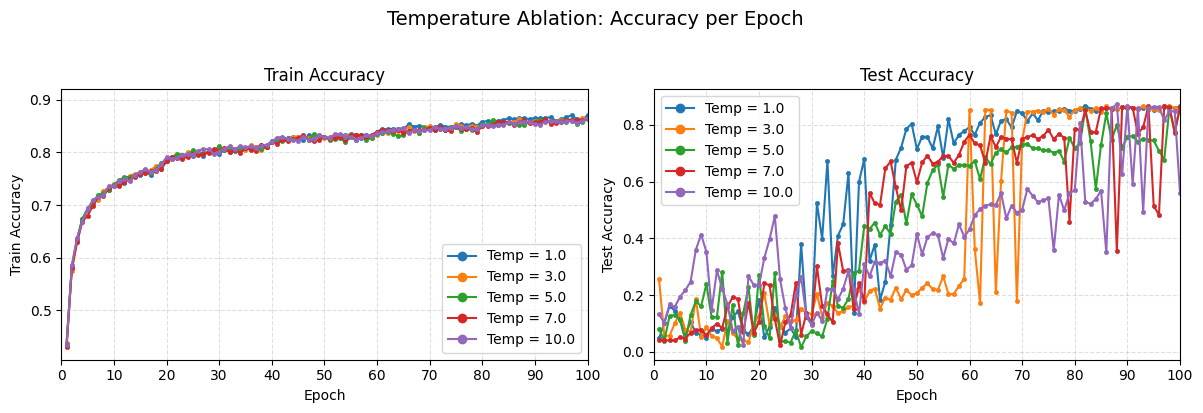

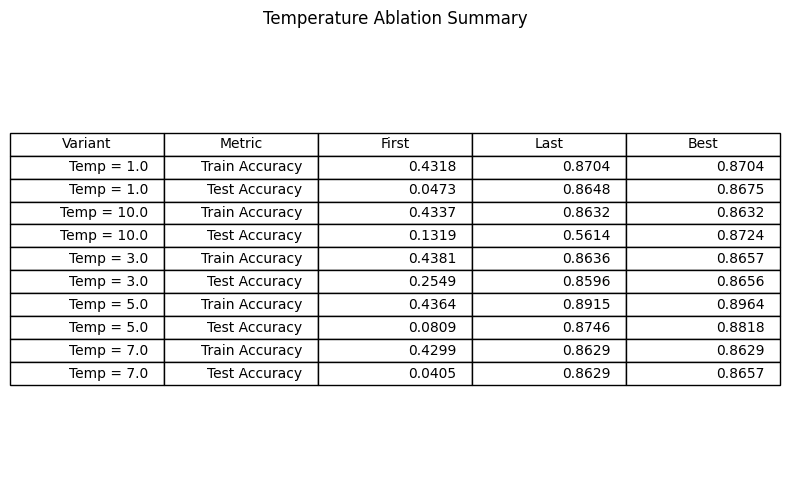

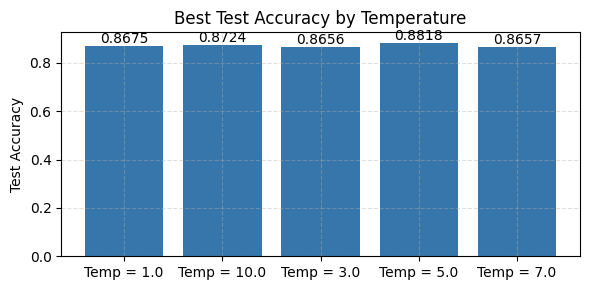

Detailed metrics:
  Temp = 1.0: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
  Temp = 3.0: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
  Temp = 5.0: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
  Temp = 7.0: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
  Temp = 10.0: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
Best-performing temperature: Temp = 5.0


In [9]:
import matplotlib.pyplot as plt
from pathlib import Path

metrics = {
    "Train Accuracy": ["train_acc"],
    "Test Accuracy": ["test_instance_acc", "test_acc"],
}

available_histories = {}
if 'results' in locals():
    for temp in sorted(results.keys()):
        history = results[temp].get('history', []) if isinstance(results[temp], dict) else []
        if history:
            available_histories[f"Temp = {temp}"] = history

if not available_histories:
    print('No training history available for visualization. Run the training cells above first.')
else:
    # --- Plot curves ---
    fig, axes = plot_training_curves(
        available_histories,
        metrics,
        title="Temperature Ablation: Accuracy per Epoch"
    )

    # Make points smaller and limit x-axis to 0–100 epochs
    for ax in np.ravel(axes):
        # Reduce scatter marker size
        for line in ax.lines:
            line.set_marker("o")
            line.set_markersize(3)  # smaller dots
            line.set_markeredgewidth(0.5)
        # Limit range
        ax.set_xlim(0, 100)
        ax.grid(True, linestyle="--", alpha=0.4)

    figures_dir = Path("../log/figures") / "temperature"
    figures_dir.mkdir(parents=True, exist_ok=True)
    curve_path = figures_dir / "accuracy_curves.png"
    fig.savefig(curve_path, dpi=180, bbox_inches="tight")
    plt.show()

    # --- Summary table ---
    summary_stats = summarize_histories(available_histories, metrics)
    table_fig, table_ax = plot_metric_table(
        summary_stats,
        title="Temperature Ablation Summary",
        value_fmt="{:.4f}",
        include_first=True
    )
    table_path = figures_dir / "accuracy_summary.png"
    table_fig.savefig(table_path, dpi=180, bbox_inches="tight")
    plt.show()

    # --- Bar chart ---
    bar_fig, bar_ax = plot_metric_bars(
        summary_stats,
        metric_name="Test Accuracy",
        title="Best Test Accuracy by Temperature",
        ylabel="Test Accuracy"
    )
    bar_ax.grid(True, linestyle="--", alpha=0.4)
    bar_path = figures_dir / "best_accuracy.png"
    bar_fig.savefig(bar_path, dpi=180, bbox_inches="tight")
    plt.show()


    def _fmt(value):
        return '-' if value is None else f"{value:.4f}"

    print('Detailed metrics:')
    for label, metric_stats in summary_stats.items():
        stats = metric_stats.get("Test Accuracy", {})
        print(f"  {label}: first={{_fmt(stats.get('first'))}}, last={{_fmt(stats.get('last'))}}, best={{_fmt(stats.get('best'))}}")

    best_label = max(
        summary_stats.items(),
        key=lambda item: item[1].get("Test Accuracy", {}).get('best') or float('-inf')
    )[0]
    print(f"Best-performing temperature: {best_label}")


## Summary and Insights

In [8]:
print('\n' + '='*60)
print('ABLATION STUDY 2.3 SUMMARY: TEMPERATURE PARAMETER')
print('='*60)

print('\n1. Final Accuracy Results:')
for temp in temp_values:
    acc = results[temp]['best_acc']
    print(f'   Temperature {temp:4.1f}: {acc:.4f}')

best_temp = max(temp_values, key=lambda t: results[t]['best_acc'])
best_acc = results[best_temp]['best_acc']
print(f'\n2. Best Temperature: {best_temp} with accuracy {best_acc:.4f}')

print('\n3. Key Insights:')
if best_temp <= 3.0:
    print('   - Lower temperature values perform best')
    print('   - More binary-like activations may be beneficial')
    print('   - Sharper gradients help with learning')
elif best_temp >= 7.0:
    print('   - Higher temperature values perform best')
    print('   - Smoother gradients facilitate training')
    print('   - Less binary activations improve performance')
else:
    print('   - Moderate temperature values (3-7) perform best')
    print('   - Balance between gradient smoothness and spiking behavior')
    print('   - Default temperature of 5.0 is well-chosen')

print('\n4. Recommendations:')
print(f'   - Use temperature={best_temp} for optimal performance')
print('   - Temperature affects both gradient flow and biological plausibility')
print('   - Consider task-specific tuning of this parameter')

print('\n' + '='*60)


ABLATION STUDY 2.3 SUMMARY: TEMPERATURE PARAMETER

1. Final Accuracy Results:
   Temperature  1.0: 0.8675
   Temperature  3.0: 0.8656
   Temperature  5.0: 0.8818
   Temperature  7.0: 0.8657
   Temperature 10.0: 0.8724

2. Best Temperature: 5.0 with accuracy 0.8818

3. Key Insights:
   - Moderate temperature values (3-7) perform best
   - Balance between gradient smoothness and spiking behavior
   - Default temperature of 5.0 is well-chosen

4. Recommendations:
   - Use temperature=5.0 for optimal performance
   - Temperature affects both gradient flow and biological plausibility
   - Consider task-specific tuning of this parameter

